In [1]:
from collections import defaultdict, deque
from typing import List, Tuple
import tqdm
import matplotlib.pyplot as plt

import numpy as np
import jax
import jax.numpy as jnp
import optax
from flax import struct
import tensorflow as tf

from controllers._base import ControllerState
from controllers.utils import append

from training.trainer import TrainState, reset_model, create_train_state, forward, forward_and_backward, apply_gradients
from training.hgd import HGDState, hypergrad_step
from training.utils import cross_entropy, mse, load_mnist, MLP, CNN

## Things we keep track of
- states (params at current iterations)
- disturbances (grads at previous iterations)
- evolve functions (based on lrs and cost fns at current iterations)

In [2]:
def gd(params, lr, cost_fn):
    """Gradient descent. """
    cost, grad = jax.value_and_grad(cost_fn)(params)
    new_params = params - lr * grad
    return (new_params, grad, cost,)

In [72]:
class MetaOptGPCState(ControllerState):
    M: jnp.ndarray  # disturbance-feedback control matrices
    
    state_dim: int = struct.field(pytree_node=False)
    H: int = struct.field(pytree_node=False)  # history of the controller, how many past disturbances to use for control
    HH: int = struct.field(pytree_node=False)  # history of the system, how many hallucination steps to take
    t: int  # time counter (for decaying learning rate)
    lr: float
    
    @classmethod
    def create(cls, 
               state_dim: int,
               m_method: str,
               H: int,
               HH: int,
               lr: float = 0.008,):
        
        if m_method == 'scalar': M = jnp.zeros((H, 1))
        elif m_method == 'diagonal': M = jnp.zeros((H, state_dim))
        elif m_method == 'full': M = jnp.zeros((H, state_dim, state_dim))
        else: raise NotImplementedError(m_method)
        
        tx = optax.inject_hyperparams(optax.sgd)(learning_rate=lr)  # M optimizer
        opt_state = tx.init(M)
        
        return cls(M=M,
                   state_dim=state_dim, H=H, HH=HH, t=0,
                   lr=lr, tx=tx, opt_state=opt_state)

@jax.jit
def compute_control(M, disturbances):
    if M.ndim == 3: control = jnp.tensordot(M, disturbances, axes=([0, 2], [0, 1]))
    else: control = (M * disturbances).sum(axis=0)
    return control

def _compute_loss(M, H, HH, initial_params, 
                  disturbances,  # past H + HH disturbances
                  evolve_fns,  # past HH evolve functions, starting at the one that would have been used to evolve `initial_params`
                  cost_fn):
    # def _evolve(params, h):
    #     return evolve_fns[h](params) + compute_control(M, jax.lax.dynamic_slice_in_dim(disturbances, h, H)), None
    # params, _ = jax.lax.scan(_evolve, initial_params, jnp.arange(HH - 1))
    params = initial_params
    for h in range(HH):
        params = evolve_fns[h](params) + compute_control(M, jax.lax.dynamic_slice_in_dim(disturbances, h, H))
    loss = cost_fn(params)
    return loss

# _grad_fn = jax.jit(jax.grad(_compute_loss, (0,)), static_argnames=('H', 'HH'))
_grad_fn = jax.grad(_compute_loss, (0,))

# @jax.jit
def update(cstate: MetaOptGPCState,
           initial_params,  # params from HH steps ago
           disturbances,  # past H + HH disturbances
           evolve_fns,  # past HH evolve functions, starting at the one that would have been used to evolve `initial_params`
           cost_fn
          ):
    # from time import perf_counter; s = perf_counter()
    
    grads = _grad_fn(cstate.M, cstate.H, cstate.HH, initial_params, disturbances, evolve_fns, cost_fn)
    # print(f'got grad in {perf_counter() - s} s'); s = perf_counter()
    updates, new_opt_state = cstate.tx.update(grads, cstate.opt_state, cstate.M)
    # print(f'got updates in {perf_counter() - s} s'); s = perf_counter()
    M = optax.apply_updates(cstate.M, updates[0])
    # print(f'applied updates in {perf_counter() - s} s'); s = perf_counter()
    cstate = cstate.replace(M=M, opt_state=new_opt_state, t=cstate.t+1)   
    # print(f'replaced cstate in {perf_counter() - s} s'); s = perf_counter()
    return cstate

In [82]:
class MetaOpt:
    param_history: deque
    grad_history: jnp.ndarray
    evolve_fn_history: Tuple
    cstate: MetaOptGPCState
    delta: float
    t: int

    def __init__(self, 
                 state_dim: int,
                 H: int, HH: int,
                 meta_lr: float, delta: float,
                 m_method: str):
        self.param_history = deque([], maxlen=HH)
        self.grad_history = jnp.zeros((H + HH, state_dim))
        self.evolve_fn_history = (None,) * HH
        self.delta = delta
        self.t = 0

        assert m_method in ['scalar', 'diagonal', 'full']
        self.cstate = MetaOptGPCState.create(state_dim, m_method, H, HH, lr=meta_lr)
        pass

    def meta_step(self, 
                  params,  # params after a step of gd
                  grads,  # grads from the step of gd that resulted in `params`
                  lr, cost_fn,  # lr and cost fn from step of gd that resulted in `params`
                 ):        
        if self.t >= self.cstate.H + self.cstate.HH:
            params = (1 - self.delta) * params + compute_control(self.cstate.M, jax.lax.dynamic_slice_in_dim(self.grad_history, -self.cstate.H, self.cstate.H))
            self.cstate = update(self.cstate, self.param_history[0], self.grad_history, self.evolve_fn_history, jax.tree_util.Partial(cost_fn))

        self.param_history.append(params)
        self.grad_history = append(self.grad_history, grads)
        self.evolve_fn_history = append(self.evolve_fn_history, jax.tree_util.Partial(lambda p: gd(p, lr, cost_fn)[0]))
        self.t += 1
        return params

# Run Things

In [102]:
def run(seed, state_dim, use_meta_opt):
    np.random.seed(seed)
    initial_params = jnp.array(np.random.randn(state_dim)) / 10
    def cost_fn(p):
        return (p ** 2).sum()
    lr = 0.01
    
    if use_meta_opt: metaopt = MetaOpt(state_dim, H=4, HH=1, meta_lr=1e-7, delta=0., m_method='scalar')

    losses = []
    params = initial_params
    for _ in tqdm.trange(500):
        params, grad, loss = gd(params, lr, cost_fn)
        losses.append(loss)
        if use_meta_opt: 
            params = metaopt.meta_step(params, grad, lr, cost_fn)
    return losses

In [103]:
state_dim = 500000
seed = 2
losses = run(seed, state_dim, False)
mo_losses = run(seed, state_dim, True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 69.63it/s]


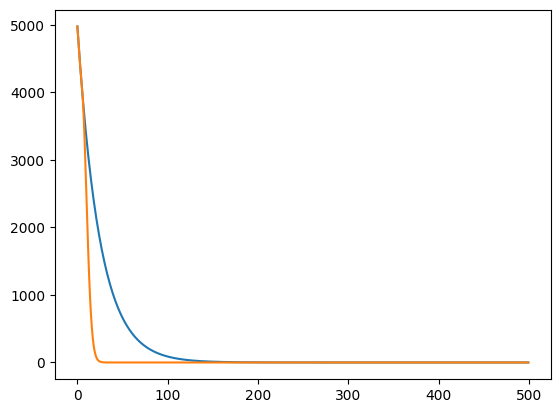

In [104]:
plt.plot(range(len(losses)), losses)
plt.plot(range(len(mo_losses)), mo_losses)